In [10]:
import pandas as pd
import numpy as np
import re

from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.metrics import f1_score

import matplotlib as mpl
import matplotlib.pyplot as plt

from datetime import datetime

%load_ext tensorboard



%matplotlib inline
mpl.rcParams['figure.figsize'] = (12, 10)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)

filepath = u"../data/resume_sentence_dataset.csv"

data = pd.read_csv(filepath)

data

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


,Sentence #,Word,Tag
0,0,Govardhana,Name
1,0,K,Name
2,0,Senior,Profil
3,0,Software,Profil
4,0,Engineer,Profil
...,...,...,...
75425,3018,Arc,O
75426,3018,"sight,",O
75427,3018,HP,O
75428,3018,Service,O


In [11]:
import math

index = data.index[data['Tag'] == "O"]
O_tagSize = math.ceil((len(index)*0.6))

drop_indices = np.random.choice(index, O_tagSize, replace=False)
#data = data.drop(drop_indices)

data["Tag"].value_counts()

O                      65524
Skills                  5268
Profil                  1006
College Name             880
Degree                   807
Companies worked at      753
Name                     342
Location                 336
Email Address            235
Date                     170
Duration                 109
Name: Tag, dtype: int64

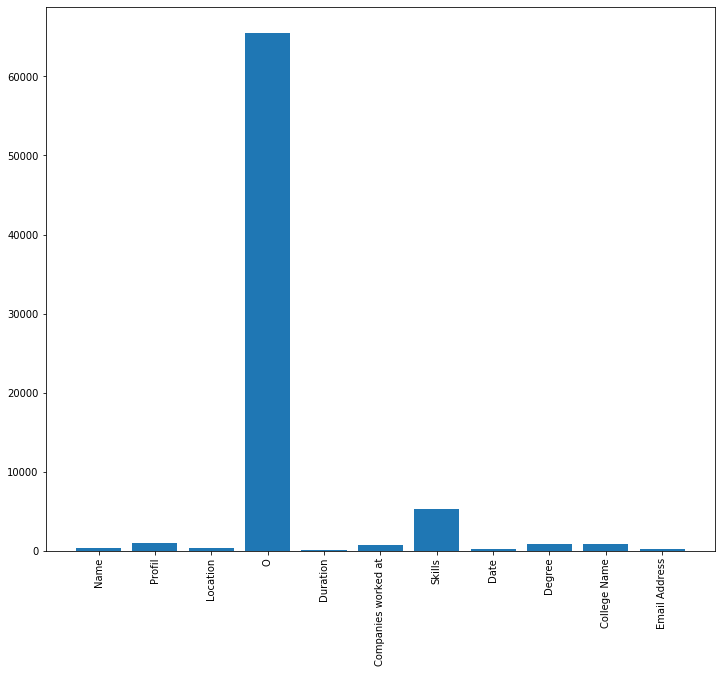

In [12]:
X = data["Word"]
y = data["Tag"]


from collections import Counter
occ = Counter(data["Tag"])

plt.xticks(rotation="vertical")
plt.bar(occ.keys(), occ.values())
plt.show()

In [13]:
max_len = 50
tags = list(set(data["Tag"].values))
n_tags = len(tags); n_tags

11

In [9]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
len(data["Word"])
n_words = len(words); n_words


16677

In [14]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w,t) for w, t in zip(s["Word"].values.tolist(),s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped[self.n_sent]
            print(s)
            self.n_sent += 1
            return s
        except:
            return None
        
getter = SentenceGetter(data)

In [16]:
sentences = getter.sentences
sentences[0]

[('Govardhana', 'Name'),
 ('K', 'Name'),
 ('Senior', 'Profil'),
 ('Software', 'Profil'),
 ('Engineer', 'Profil'),
 ('Bengaluru', 'Location'),
 ('Karnataka', 'O'),
 ('Total', 'O'),
 ('IT', 'O'),
 ('experience', 'O'),
 ('5', 'Duration'),
 ('Years', 'Duration'),
 ('6', 'Duration'),
 ('Months', 'Duration'),
 ('Cloud', 'Companies worked at'),
 ('Lending', 'Companies worked at'),
 ('Solutions', 'Companies worked at'),
 ('INC', 'O'),
 ('4', 'O'),
 ('Month', 'O'),
 ('Salesforce', 'Profil'),
 ('Developer', 'Profil'),
 ('Oracle', 'Companies worked at'),
 ('5', 'Duration'),
 ('Years', 'Duration')]

In [24]:
#pad word to a length of 50 (why ? Keras need to have same length for each input in the neural net)
max_len = 50
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [25]:
from keras.preprocessing.sequence import pad_sequences

X = [[word2idx[w[0]] for w in s] for s in sentences]
y = [[tag2idx[w[1]] for w in s] for s in sentences]


idx2word = {i: w for w, i in word2idx.items()}

idx2tag = {i: w for w, i in tag2idx.items()}


X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=n_words - 1)
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=0)

In [26]:
# change label to categorical
from keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags) for i in y]

In [27]:

# split dataset into train (input & label) test (input & label)
from sklearn.model_selection import train_test_split

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3)
print(len(X_tr), len(X_te), len(y_tr), len(y_te))


20181 8650 20181 8650


In [28]:
import keras
from keras_contrib.layers import CRF
from keras_contrib import metrics,losses


logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [29]:
import gensim
word_vectors  = gensim.models.Word2Vec.load("saved_model/word2vecEmbedding").wv

MAX_NB_WORDS = len(word_vectors.vocab)
WV_DIM = 50

nb_words = min(MAX_NB_WORDS, len(word_vectors.vocab))

# we initialize the matrix with random numbers
wv_matrix = (np.random.rand(n_words, WV_DIM) - 0.5) / 5.0
for word, i in word2idx.items():
    if i >= MAX_NB_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        # words not found in embedding index will be all-zeros.
        wv_matrix[i] = embedding_vector
    except:
        pass
len(word_vectors.vocab)

2414

In [30]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional,SpatialDropout1D
from keras.layers.normalization import BatchNormalization


embedding_layer = Embedding(n_words,
                     WV_DIM,
                     mask_zero=False,
                     weights=[wv_matrix],
                     input_length=50,
                     trainable=False)

input = Input(shape=(max_len,))
model = embedding_layer(input)
model = SpatialDropout1D(0.2)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.2))(model)  # variational biLSTM
out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)  # softmax output layer

crf = CRF(n_tags)
out = crf(model)

model = Model(input, out)
model.summary()


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 50)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 50, 50)            736500    
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 50, 50)            0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 50, 200)           120800    
_________________________________________________________________
crf_2 (CRF)                  (None, 50, 11)            2354      
Total params: 859,654
Trainable params: 859,654
Non-trainable params: 0
_________________________________________________________________


In [31]:
model.compile(optimizer="rmsprop", loss=losses.crf_loss, metrics=[metrics.crf_accuracy])

In [41]:
history = model.fit(X_tr, np.array(y_tr), batch_size=256, epochs=5, validation_split=0.3, verbose=1,shuffle=True,class_weight=value)

Train on 14126 samples, validate on 6055 samples
Epoch 1/5
14126/14126 [==============================] - 61s 4ms/step - loss: 0.0175 - crf_accuracy: 0.9958 - val_loss: 0.0154 - val_crf_accuracy: 0.9954
Epoch 2/5
14126/14126 [==============================] - 65s 5ms/step - loss: 0.0133 - crf_accuracy: 0.9964 - val_loss: 0.0127 - val_crf_accuracy: 0.9964
Epoch 3/5
14126/14126 [==============================] - 66s 5ms/step - loss: 0.0107 - crf_accuracy: 0.9971 - val_loss: 0.0103 - val_crf_accuracy: 0.9968
Epoch 4/5
14126/14126 [==============================] - 65s 5ms/step - loss: 0.0086 - crf_accuracy: 0.9974 - val_loss: 0.0086 - val_crf_accuracy: 0.9971
Epoch 5/5
14126/14126 [==============================] - 67s 5ms/step - loss: 0.0067 - crf_accuracy: 0.9977 - val_loss: 0.0071 - val_crf_accuracy: 0.9971


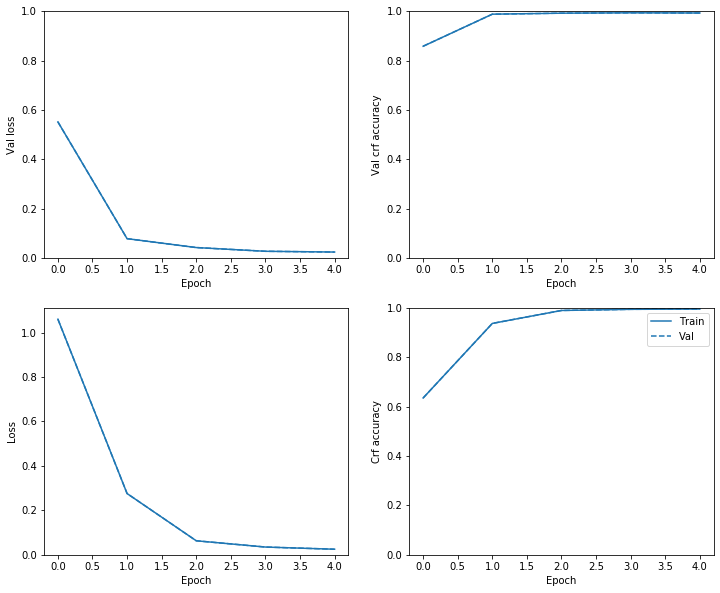

In [34]:
def plot_metrics(history):
    metrics =  ['val_loss', 'val_crf_accuracy', 'loss', 'crf_accuracy']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history[metric],
             color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
              plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
              plt.ylim([0.8,1])
        else:
              plt.ylim([0,1])

    plt.legend()
plot_metrics(history)

In [42]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

idx2tag = {i: w for w, i in tag2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i])
        out.append(out_i)
    return out


y_pred = model.predict(X_te,verbose=1)

pred_labels = pred2label(y_pred)
test_labels = pred2label(y_te)

print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))
 
print(classification_report(test_labels, pred_labels))

8650/8650 [==============================] - 19s 2ms/step
F1-score: 99.0%
                     precision    recall  f1-score   support

             Profil       0.95      0.92      0.93       895
           Duration       1.00      1.00      1.00      8665
           Location       0.98      0.97      0.98       912
      Email Address       1.00      1.00      1.00     19885
               Name       0.99      0.98      0.98       818
             Skills       0.98      1.00      0.99     20196
             Degree       0.96      0.95      0.95       847
               Date       0.98      0.94      0.96       810
Companies worked at       0.96      0.91      0.93       916
       College Name       0.95      0.93      0.94       842

          micro avg       0.99      0.99      0.99     54786
          macro avg       0.99      0.99      0.99     54786



In [36]:

##overfitted model no good

test_sentence = ["Developer" ,"in", "HTML5", ",", "JavaScript", "and", "CSS3", "(Examen 70-480)"
                ,"Oracle", ".","Developer" ,"Java", "Programmer","2012","to","2013"]

x_test_sent = pad_sequences(sequences=[[word2idx.get(w, 0) for w in test_sentence]],
                            padding="post", value=0, maxlen=max_len)
p = model.predict(np.array([x_test_sent[0]]))

p = np.argmax(p, axis=-1)
print("{:15}||{}".format("Word", "Prediction"))
print(30 * "=")
for w, pred in zip(test_sentence, p[0]):
    print("{:15}: {:5}".format(w, tags[pred]))
    
    


Word           ||Prediction
Developer      : O    
in             : O    
HTML5          : O    
,              : O    
JavaScript     : O    
and            : O    
CSS3           : O    
(Examen 70-480): O    
Oracle         : O    
.              : O    
Developer      : O    
Java           : O    
Programmer     : O    
2012           : O    
to             : O    
2013           : O    


In [37]:
## compute weight for regularization
from sklearn.utils import class_weight

y_ints = [y.argmax() for y in y_tr]
value = class_weight.compute_class_weight('balanced',np.unique(y_ints),y_ints)

print(value)

[0.98477529 0.9927686  1.0036304  1.00253353 1.00915092 1.02608298
 0.98371923 0.99008978 1.00472966 1.00253353 1.00143906]


In [38]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional



input = Input(shape=(max_len,))
model2 = embedding_layer(input)
model2 = Bidirectional(LSTM(units=64, return_sequences=True))(model2)  # variational biLSTM
out = TimeDistributed(Dense(n_tags, activation="softmax"))(model2)  # softmax output layer
crf = CRF(n_tags)
out = crf(model2)

model2 = Model(input, out)
model2.summary()

model2.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])
history = model2.fit(X_tr, np.array(y_tr), batch_size=256, epochs=5, validation_split=0.1, verbose=1,shuffle=True,class_weight=value)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 50)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 50, 50)            736500    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 50, 128)           58880     
_________________________________________________________________
crf_3 (CRF)                  (None, 50, 11)            1562      
Total params: 796,942
Trainable params: 796,942
Non-trainable params: 0
_________________________________________________________________


C:\Users\Cheikh\Anaconda3\envs\tensorflow\lib\site-packages\keras_contrib\layers\crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
C:\Users\Cheikh\Anaconda3\envs\tensorflow\lib\site-packages\keras_contrib\layers\crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '
C:\Users\Cheikh\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 18162 samples, validate on 2019 samples
Epoch 1/5
18162/18162 [==============================] - 37s 2ms/step - loss: 0.7538 - crf_viterbi_accuracy: 0.8077 - val_loss: 0.1606 - val_crf_viterbi_accuracy: 0.9752
Epoch 2/5
18162/18162 [==============================] - 37s 2ms/step - loss: 0.0719 - crf_viterbi_accuracy: 0.9905 - val_loss: 0.0374 - val_crf_viterbi_accuracy: 0.9923
Epoch 3/5
18162/18162 [==============================] - 40s 2ms/step - loss: 0.0239 - crf_viterbi_accuracy: 0.9948 - val_loss: 0.0212 - val_crf_viterbi_accuracy: 0.9939
Epoch 4/5
15104/18162 [=======================>......] - ETA: 6s - loss: 0.0130 - crf_viterbi_accuracy: 0.9958

KeyboardInterrupt: 

In [ ]:
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

idx2tag = {i: w for w, i in tag2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out


y_pred = model.predict(X_te,verbose=1)

pred_labels = pred2label(y_pred)
test_labels = pred2label(y_te)

print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))
 
print(classification_report(test_labels, pred_labels))

In [ ]:
test_sentence = ["Data","engineer" ,".", "HTML5", "with", "JavaScript", "and", "CSS3"
                ,"Oracle","from","2012","to","2013"]

x_test_sent = pad_sequences(sequences=[[word2idx.get(w, 0) for w in test_sentence]],
                            padding="post", value=0, maxlen=max_len)
p = model2.predict(np.array([x_test_sent[0]]))

p = np.argmax(p, axis=-1)
print("{:15}||{}".format("Word", "Prediction"))
print(30 * "=")
for w, pred in zip(test_sentence, p[0]):
    print("{:15}: {:5}".format(w, tags[pred]))

In [4]:
## try word embedding format word2vec
import multiprocessing
import gensim

from gensim.models import Word2Vec
import logging
from time import time

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

sentences = data.groupby("Sentence #").apply(lambda x : [w for w in x["Word"]])
type(sentences)
sentences = sentences.tolist()
print(len(sentences))

['Govardhana',
 'K',
 'Senior',
 'Software',
 'Engineer',
 'Bengaluru',
 'Karnataka',
 'Total',
 'IT',
 'experience',
 '5',
 'Years',
 '6',
 'Months',
 'Cloud',
 'Lending',
 'Solutions',
 'INC',
 '4',
 'Month',
 'Salesforce',
 'Developer',
 'Oracle',
 '5',
 'Years']

In [3]:
cores = multiprocessing.cpu_count()
cores

4

In [12]:
w2v_model = Word2Vec(min_count=5,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))
w2v_model.corpus_count

2020-05-20 23:03:03,534 : INFO : collecting all words and their counts
2020-05-20 23:03:03,536 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-05-20 23:03:03,553 : INFO : collected 14729 word types from a corpus of 75430 raw words and 3018 sentences
2020-05-20 23:03:03,555 : INFO : Loading a fresh vocabulary
2020-05-20 23:03:03,567 : INFO : effective_min_count=5 retains 2279 unique words (15% of original 14729, drops 12450)
2020-05-20 23:03:03,570 : INFO : effective_min_count=5 leaves 56626 word corpus (75% of original 75430, drops 18804)
2020-05-20 23:03:03,585 : INFO : deleting the raw counts dictionary of 14729 items
2020-05-20 23:03:03,586 : INFO : sample=6e-05 downsamples 1204 most-common words
2020-05-20 23:03:03,587 : INFO : downsampling leaves estimated 22261 word corpus (39.3% of prior 56626)
2020-05-20 23:03:03,596 : INFO : estimated required memory for 2279 words and 300 dimensions: 6609100 bytes
2020-05-20 23:03:03,598 : INFO : resetting laye

Time to build vocab: 0.01 mins


3018

In [13]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

2020-05-20 23:03:08,370 : INFO : training model with 3 workers on 2279 vocabulary and 300 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2
2020-05-20 23:03:08,458 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-05-20 23:03:08,468 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-05-20 23:03:08,480 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-05-20 23:03:08,482 : INFO : EPOCH - 1 : training on 75430 raw words (22157 effective words) took 0.1s, 214983 effective words/s
2020-05-20 23:03:08,558 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-05-20 23:03:08,570 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-05-20 23:03:08,583 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-05-20 23:03:08,584 : INFO : EPOCH - 2 : training on 75430 raw words (22252 effective words) took 0.1s, 234604 effective words/s
2020-05-20 23:03:08,658 : INFO : worke

2020-05-20 23:03:11,089 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-05-20 23:03:11,105 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-05-20 23:03:11,127 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-05-20 23:03:11,131 : INFO : EPOCH - 21 : training on 75430 raw words (22150 effective words) took 0.2s, 129711 effective words/s
2020-05-20 23:03:11,227 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-05-20 23:03:11,241 : INFO : worker thread finished; awaiting finish of 1 more threads
2020-05-20 23:03:11,254 : INFO : worker thread finished; awaiting finish of 0 more threads
2020-05-20 23:03:11,256 : INFO : EPOCH - 22 : training on 75430 raw words (22338 effective words) took 0.1s, 189978 effective words/s
2020-05-20 23:03:11,352 : INFO : worker thread finished; awaiting finish of 2 more threads
2020-05-20 23:03:11,366 : INFO : worker thread finished; awaiting finish of 1 more threads
2020

Time to train the model: 0.06 mins


In [14]:
w2v_model.save("saved_model/word2vecEmbedding")
word_vectors = w2v_model.wv
print("Number of word vectors: {}".format(len(word_vectors.vocab)))

2020-05-20 23:03:17,079 : INFO : saving Word2Vec object under saved_model/word2vecEmbedding, separately None
2020-05-20 23:03:17,081 : INFO : not storing attribute vectors_norm
2020-05-20 23:03:17,082 : INFO : not storing attribute cum_table
2020-05-20 23:03:17,156 : INFO : saved saved_model/word2vecEmbedding


Number of word vectors: 2279
